<div style="color:black;
           display:fill;
           border-radius:1px;
           background-color:#FFA500;
           align:center;">

<p style="padding: 1px;
              color:white;">
<center>
    
# Factor Analysis to reduce feature dimensions

### Theory

Unnessecary features or redundency can result in low performance in ML classification algorithm and also cost more time in training the data.
Depending on the type of features we have, we can use various techniques to reduce the dimensions of features:

- Principle Component Analysis (PCA) for Numerical Features.
- Multiple Correspondence Analysis (MCA) for Categorical Features.
- Factor Analysis of Mixed Data (FAMD) for mixed data of categorical and numerical. 

FAMD is a combination of PCA and MCA methods. Our aim in this notebook is to select few components of FAMD as the new features 
that explains most of the variance and see how ML classification predicts survivability based on FAMD components. Since titanic
dataset is made of categorical features (Sex, Embarked etc.) and Numerical (Age,Fare etc.), we can safely assume FAMD will do
some good in feature reduction. 


### Install prince package which contains MCA tool

In [1]:
pip install --user prince


Note: you may need to restart the kernel to use updated packages.


### Import relevant libraries

In [2]:

import pandas as pd
import numpy as np
import prince
import seaborn as sns
import matplotlib.pyplot as plt

### Data import and preprocessing for MCA


In [3]:
def clean_data(df):
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True); # take care of missing Embarked values
    df['Age'] = df['Age'].fillna(df['Age'].mean()); # take care of missing Age values
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean()); # take care of missing Fare values
    df = df.drop(columns=['Cabin','Ticket','PassengerId'], axis=1); # drop unwanted columns that do not contribute to survivability
    return df

def feature_engineer(df):
    df['FamilySize'] = df['SibSp'] + df['Parch']; # add new feature of family size
    df = df.drop(columns=['Name'], axis=1); # once titles are extracted, drop the names
    # add a new column indicating adult or not
    adult = [];
    for i in range(len(df['Age'])):
        X = df['Age'].iloc[i];
        if(X=='adult'):
            adult.append(0);
        else:
            adult.append(1);
    df['adult'] = adult;
    return df

def preprocess(df):
    df = clean_data(df);
    df = feature_engineer(df);
    return df

In [4]:
# import the data as pandas dataframe
test  = pd.read_csv('../input/titanic/test.csv');
train = pd.read_csv('../input/titanic/train.csv');
PID   = test['PassengerId']; # save passenger ID for submission

# process the data

train = preprocess(train);
test  = preprocess(test); # do the same processing as we did for train

train = train.iloc[:, ::-1]; # I want to keep survived at last column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   adult       891 non-null    int64  
 1   FamilySize  891 non-null    int64  
 2   Embarked    891 non-null    object 
 3   Fare        891 non-null    float64
 4   Parch       891 non-null    int64  
 5   SibSp       891 non-null    int64  
 6   Age         891 non-null    float64
 7   Sex         891 non-null    object 
 8   Pclass      891 non-null    int64  
 9   Survived    891 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 69.7+ KB


### Instantiate FAMD class and visualize the FAMD components

[0.24870529 0.20598812 0.17115264 0.14241702 0.09884178]


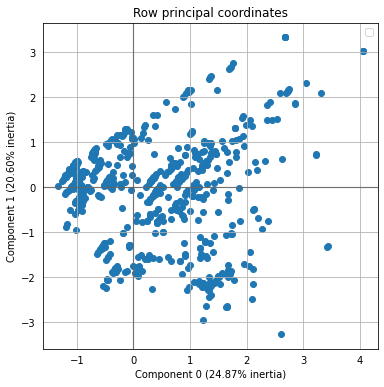

In [5]:
famd = prince.FAMD(n_components = 5, n_iter = 5, random_state = 101);
# get principal components
X = train[train.columns[0:-1]]; # include everything except the survival column.
famd = famd.fit(X);
X_components = famd.U_;
print(famd.explained_inertia_);
famd.plot_row_coordinates(X = X);

Text(0, 0.5, 'component2 17.11% variance')

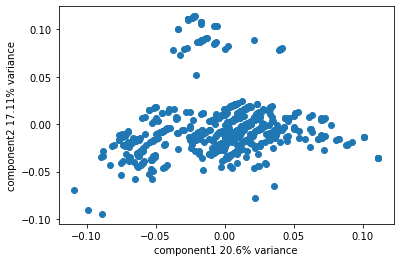

In [6]:
plt.scatter(X_components[:,1],X_components[:,2]);
plt.xlabel('component1 20.6% variance') 
plt.ylabel('component2 17.11% variance') 

Text(0, 0.5, 'explained variance')

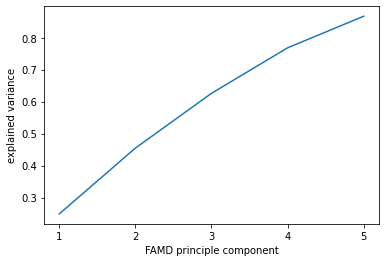

In [7]:
plt.plot(np.cumsum(famd.explained_inertia_))
plt.xticks(np.arange(5),np.arange(5)+1) 
plt.xlabel('FAMD principle component') 
plt.ylabel('explained variance') 

### Interpretation

- Looks like first five components of FAMD capture 85% of variables.
- Next we will run SVM predictions on FAMD components to test model accuracy.

<div style="color:black;
           display:fill;
           border-radius:1px;
           background-color:#FFA500;
           align:center;">

<p style="padding: 1px;
              color:white;">
<center>
    
# Support Vector Machine Classification

### Theory

Support vector machine (SVM) is a supervised machine learning classification technique that fits a line/plane/hyperplane between different classes.SVM learns decision boundary between classes from maximizing the distance from the boundary line to theeach points in the classes. The datapoints that lie along the border of different classes are called support vectors and by measuring the distance between data points to support vectors, classification decision is made.

Different kernels can be used to compute the distance such as Polynomial kernel or Gaussian kernel (a.k.a radial basis function). Learning basis functions in SVM took me back to good old days of learning finite element analysis where different basis functions were used to solve differential equation. Anyway lets comeback to SVM.

SVM requires all features to be on same scale. Hence our previous exercise of using Factor Analyze to reduce dimensionality might come handy now. Lets see how it performs!SVM is also known to be very sensitive to the tuning parameter namely the gamma parameter and the regularization (C-term).


### Model Accuracy
To test model accuracy, we will split the training data into subset of train and test.

First we need to create a new dataframe where features are components from FAMD analysis done before!

In [8]:
survived = np.array(train['Survived']).reshape(891,1);
df = np.concatenate([X_components,survived],axis=1);
famd_train = pd.DataFrame(data = df,columns =['famd1','famd2','famd3','famd4','famd5','Survived']);
famd_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   famd1     891 non-null    float64
 1   famd2     891 non-null    float64
 2   famd3     891 non-null    float64
 3   famd4     891 non-null    float64
 4   famd5     891 non-null    float64
 5   Survived  891 non-null    float64
dtypes: float64(6)
memory usage: 41.9 KB


### train-test split of train data for model accuracy

In [9]:
from sklearn.model_selection import train_test_split

# train test split
X = famd_train.drop(columns = ['Survived'],axis=1);
y = famd_train['Survived'];
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X,y, test_size=0.2, random_state=10);
y_train_m.head()

57     0.0
717    1.0
431    1.0
633    0.0
163    0.0
Name: Survived, dtype: float64

### SVM model on FAMD components

In [10]:
from sklearn.svm import SVC
model = SVC(random_state=42, probability=True);
model.fit(X_train_m, y_train_m);
y_pred_m = model.predict(X_test_m);
from sklearn import metrics 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test_m, y_pred_m));


ACCURACY OF THE MODEL:  0.8156424581005587


#### Comments

- So instead of using 8 original features, we used 5 FAMD components and yet achieved similar accuracy of 81%.
- Now lets do the same on actual test data for competition submission.

### Predicting on the test data for actual competition submission


In [11]:
famd = famd.fit(test);
test_famd_components = famd.U_;
y_submission = model.predict(test_famd_components);
output = pd.DataFrame({'PassengerId': PID, 'Survived': y_submission})
output.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


### The FAMD predicted with a score of 74% on the competition forum which is quite good. We had only 5 features.

- It would be nice to repeat this for having only 3 FAMD components. 
- Also converting the features into categorical values and then trying MCA analysis.